# Voice Command Recognition

## Prepare audio data for voice command recognition
We then generate spectrograms of each word. We mix in background noise with the words to make it a more realistic audio sample.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Get the dataset on google drive

In [ ]:
import os
import zipfile


# Path to the zip file
zip_file_path = "/content/drive/MyDrive/speech_data.zip"

# Path to extract the contents
extracted_folder_path = "/content/speech_data"

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# Verify the contents of the extracted folder
extracted_files = os.listdir(extracted_folder_path)
print("Contents of the extracted folder:")
print(extracted_files)

Contents of the extracted folder:
['speech_data']


In [ ]:
#!cp -r "/content/drive/MyDrive/speech_data" "/content/"

In [ ]:
#!rm -r "speech_data"

In [ ]:
!pip install tensorflow

In [ ]:
!pip install tensorflow-io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 11.9 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import soundfile as sf

# Define the directory containing your input WAV files
input_directory = "speech_data/speech_data/slow"

# Define the directory to save the converted WAV files
output_directory = "speech_data/speech_data/slow"

# Ensure the output directory exists, create it if it doesn't
os.makedirs(output_directory, exist_ok=True)

# Define the constants
EXPECTED_SAMPLES = 16000
NOISE_FLOOR = 0.1
MINIMUM_VOICE_LENGTH = EXPECTED_SAMPLES // 4

# Function to convert WAV files
def convert_wav(input_file, output_file):
    # Load the WAV file
    data, samplerate = sf.read(input_file)

    # Check if the audio is sampled at 16KHz
    if samplerate != 16000:
        print(f"Warning: {input_file} is not sampled at 16KHz.")

    # Check if the audio is 1 second in length
    if len(data) != EXPECTED_SAMPLES:
        print(f"Warning: {input_file} is not 1 second in length.")

    # Check if any audio is present (above noise floor)
    if np.max(data) < NOISE_FLOOR:
        print(f"Warning: {input_file} does not contain enough audio.")
        return

    # Save the converted WAV file
    sf.write(output_file, data, samplerate)

# Iterate over each WAV file in the input directory
for file_name in os.listdir(input_directory):
    if file_name.endswith(".wav"):
        input_file_path = os.path.join(input_directory, file_name)
        output_file_path = os.path.join(output_directory, file_name)
        convert_wav(input_file_path, output_file_path)

print("Conversion completed.")

Conversion completed.


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.io import gfile
import tensorflow_io as tfio
from tensorflow.python.ops import gen_audio_ops as audio_ops
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from tensorflow.python.ops import gen_audio_ops as audio_ops

In [ ]:
SPEECH_DATA='speech_data/speech_data'

In [ ]:
# The audio is all sampled at 16KHz and should all be 1 second in length - so 1 second is 16000 samples
EXPECTED_SAMPLES=16000
# Noise floor to detect if any audio is present
NOISE_FLOOR=0.1
# How many samples should be abover the noise floor?
MINIMUM_VOICE_LENGTH=EXPECTED_SAMPLES/4

In [ ]:
# list of folders we want to process in the speech_data folder
command_words = [
    'slow',
    'left',
    'right',
    'stop',
    '_invalid',
]
nonsense_words = [
   'noise',
   'unknown'
   'backward',
   'forward',
   'down',
   'eight',
   'four',
   'go',
   'nine',
   'no',
   'off',
   'wow',
   'yes',
   'up',
   'bed',
   'cat',
   'house',
   'seven',
   'visual',
   'two',
   'zero',
   'tree',
   'six',
   'marvin',
   'learn',
   'happy',
   'follow',
   'dog',
   'bird'
   'three',
   'sheila',
   'five',
]

In [ ]:
# get all the files in a directory
def get_files(word):
    return gfile.glob(SPEECH_DATA + '/'+word+'/*.wav')

# get the location of the voice
def get_voice_position(audio, noise_floor):
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    return tfio.audio.trim(audio, axis=0, epsilon=noise_floor)

# Work out how much of the audio file is actually voice
def get_voice_length(audio, noise_floor):
    position = get_voice_position(audio, noise_floor)
    return (position[1] - position[0]).numpy()

# is enough voice present?
def is_voice_present(audio, noise_floor, required_length):
    voice_length = get_voice_length(audio, noise_floor)
    return voice_length >= required_length

# is the audio the correct length?
def is_correct_length(audio, expected_length):
    return (audio.shape[0]==expected_length).numpy()


def is_valid_file(file_name):
    # load the audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_name)
    # check the file is long enough
    if not is_correct_length(audio_tensor, EXPECTED_SAMPLES):
        return False
    # convert the audio to an array of floats and scale it to betweem -1 and 1
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    # is there any voice in the audio?
    if not is_voice_present(audio, NOISE_FLOOR, MINIMUM_VOICE_LENGTH):
        return False
    return True


In [ ]:
def get_spectrogram(audio):
    # normalise the audio
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    # create the spectrogram
    spectrogram = audio_ops.audio_spectrogram(audio,
                                              window_size=320,
                                              stride=160,
                                              magnitude_squared=True).numpy()
    # reduce the number of frequency bins in our spectrogram to a more sensible level
    spectrogram = tf.nn.pool(
        input=tf.expand_dims(spectrogram, -1),
        window_shape=[1, 6],
        strides=[1, 6],
        pooling_type='AVG',
        padding='SAME')
    spectrogram = tf.squeeze(spectrogram, axis=0)
    spectrogram = np.log10(spectrogram + 1e-6)
    return spectrogram

In [ ]:
# process a file into its spectrogram
def process_file(file_path):
    # load the audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_path)
    # convert the audio to an array of floats and scale it to betweem -1 and 1
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    # randomly reposition the audio in the sample
    voice_start, voice_end = get_voice_position(audio, NOISE_FLOOR)
    end_gap=len(audio) - voice_end
    random_offset = np.random.uniform(0, voice_start+end_gap)
    audio = np.roll(audio,-random_offset+end_gap)
    # add some random background noise
    background_volume = np.random.uniform(0, 0.1)
    # get the background noise files
    background_files = get_files('_background_noise_')
    background_file = np.random.choice(background_files)
    background_tensor = tfio.audio.AudioIOTensor(background_file)
    background_start = np.random.randint(0, len(background_tensor) - 16000)
    # normalise the background noise
    background = tf.cast(background_tensor[background_start:background_start+16000], tf.float32)
    background = background - np.mean(background)
    background = background / np.max(np.abs(background))
    # mix the audio with the scaled background
    audio = audio + background_volume * background
    # get the spectrogram
    return get_spectrogram(audio)

In [ ]:
train = []
validate = []
test = []

TRAIN_SIZE=0.8
VALIDATION_SIZE=0.1
TEST_SIZE=0.1

In [ ]:
def process_files(file_names, label, repeat=1):
    file_names = tf.repeat(file_names, repeat).numpy()
    return [(process_file(file_name), label) for file_name in tqdm(file_names, desc=f"{word} ({label})", leave=False)]

# process the files for a word into the spectrogram and one hot encoding word value
def process_word(word, label, repeat=1):
    # get a list of files names for the word
    file_names = [file_name for file_name in tqdm(get_files(word), desc="Checking", leave=False) if is_valid_file(file_name)]
    # randomly shuffle the filenames
    np.random.shuffle(file_names)
    # split the files into train, validate and test buckets
    train_size=int(TRAIN_SIZE*len(file_names))
    validation_size=int(VALIDATION_SIZE*len(file_names))
    test_size=int(TEST_SIZE*len(file_names))
    # get the training samples
    train.extend(
        process_files(
            file_names[:train_size],
            label,
            repeat=repeat
        )
    )
    # and the validation samples
    validate.extend(
        process_files(
            file_names[train_size:train_size+validation_size],
            label,
            repeat=repeat
        )
    )
    # and the test samples
    test.extend(
        process_files(
            file_names[train_size+validation_size:],
            label,
            repeat=repeat
        )
    )


# process all the command words
for word in tqdm(command_words, desc="Processing words"):
    if '_' not in word:
        repeat = 40 if word in ('slow','left', 'right', 'stop') else 20
        process_word(word, command_words.index(word), repeat=repeat)

try:
  # all the nonsense words
  for word in tqdm(nonsense_words, desc="Processing words"):
      if '_' not in word:
          process_word(word, command_words.index('_invalid'), repeat=1)
except Exception as e:
  print(f'Error: {e}')

print(len(train), len(test), len(validate))

Processing words:   0%|          | 0/5 [00:00<?, ?it/s]

Checking:   0%|          | 0/530 [00:00<?, ?it/s]

slow (0):   0%|          | 0/16640 [00:00<?, ?it/s]

slow (0):   0%|          | 0/2080 [00:00<?, ?it/s]

slow (0):   0%|          | 0/2080 [00:00<?, ?it/s]

Checking:   0%|          | 0/994 [00:00<?, ?it/s]

left (1):   0%|          | 0/18360 [00:00<?, ?it/s]

left (1):   0%|          | 0/2280 [00:00<?, ?it/s]

left (1):   0%|          | 0/2320 [00:00<?, ?it/s]

Checking:   0%|          | 0/1044 [00:00<?, ?it/s]

right (2):   0%|          | 0/22520 [00:00<?, ?it/s]

right (2):   0%|          | 0/2800 [00:00<?, ?it/s]

right (2):   0%|          | 0/2840 [00:00<?, ?it/s]

Checking:   0%|          | 0/1044 [00:00<?, ?it/s]

stop (3):   0%|          | 0/20920 [00:00<?, ?it/s]

stop (3):   0%|          | 0/2600 [00:00<?, ?it/s]

stop (3):   0%|          | 0/2640 [00:00<?, ?it/s]

Processing words:   0%|          | 0/30 [00:00<?, ?it/s]

Checking: 0it [00:00, ?it/s]

noise (4): 0it [00:00, ?it/s]

noise (4): 0it [00:00, ?it/s]

noise (4): 0it [00:00, ?it/s]

Checking: 0it [00:00, ?it/s]

unknownbackward (4): 0it [00:00, ?it/s]

unknownbackward (4): 0it [00:00, ?it/s]

unknownbackward (4): 0it [00:00, ?it/s]

Checking:   0%|          | 0/1557 [00:00<?, ?it/s]

forward (4):   0%|          | 0/1113 [00:00<?, ?it/s]

forward (4):   0%|          | 0/139 [00:00<?, ?it/s]

forward (4):   0%|          | 0/140 [00:00<?, ?it/s]

Checking:   0%|          | 0/3917 [00:00<?, ?it/s]

down (4):   0%|          | 0/2623 [00:00<?, ?it/s]

down (4):   0%|          | 0/327 [00:00<?, ?it/s]

down (4):   0%|          | 0/329 [00:00<?, ?it/s]

Checking:   0%|          | 0/3787 [00:00<?, ?it/s]

eight (4):   0%|          | 0/1858 [00:00<?, ?it/s]

eight (4):   0%|          | 0/232 [00:00<?, ?it/s]

eight (4):   0%|          | 0/233 [00:00<?, ?it/s]

Checking:   0%|          | 0/3728 [00:00<?, ?it/s]

four (4):   0%|          | 0/2250 [00:00<?, ?it/s]

four (4):   0%|          | 0/281 [00:00<?, ?it/s]

four (4):   0%|          | 0/282 [00:00<?, ?it/s]

Checking:   0%|          | 0/3880 [00:00<?, ?it/s]

go (4):   0%|          | 0/2157 [00:00<?, ?it/s]

go (4):   0%|          | 0/269 [00:00<?, ?it/s]

go (4):   0%|          | 0/271 [00:00<?, ?it/s]

Checking:   0%|          | 0/3934 [00:00<?, ?it/s]

nine (4):   0%|          | 0/2758 [00:00<?, ?it/s]

nine (4):   0%|          | 0/344 [00:00<?, ?it/s]

nine (4):   0%|          | 0/346 [00:00<?, ?it/s]

Checking:   0%|          | 0/3941 [00:00<?, ?it/s]

no (4):   0%|          | 0/2464 [00:00<?, ?it/s]

no (4):   0%|          | 0/308 [00:00<?, ?it/s]

no (4):   0%|          | 0/309 [00:00<?, ?it/s]

Checking:   0%|          | 0/3745 [00:00<?, ?it/s]

off (4):   0%|          | 0/1188 [00:00<?, ?it/s]

off (4):   0%|          | 0/148 [00:00<?, ?it/s]

off (4):   0%|          | 0/150 [00:00<?, ?it/s]

Checking:   0%|          | 0/2123 [00:00<?, ?it/s]

wow (4):   0%|          | 0/1356 [00:00<?, ?it/s]

wow (4):   0%|          | 0/169 [00:00<?, ?it/s]

wow (4):   0%|          | 0/170 [00:00<?, ?it/s]

Checking:   0%|          | 0/4044 [00:00<?, ?it/s]

yes (4):   0%|          | 0/2364 [00:00<?, ?it/s]

yes (4):   0%|          | 0/295 [00:00<?, ?it/s]

yes (4):   0%|          | 0/297 [00:00<?, ?it/s]

Checking:   0%|          | 0/3723 [00:00<?, ?it/s]

up (4):   0%|          | 0/790 [00:00<?, ?it/s]

up (4):   0%|          | 0/98 [00:00<?, ?it/s]

up (4):   0%|          | 0/100 [00:00<?, ?it/s]

Checking:   0%|          | 0/1120 [00:00<?, ?it/s]

bed (4):   0%|          | 0/550 [00:00<?, ?it/s]

bed (4):   0%|          | 0/68 [00:00<?, ?it/s]

bed (4):   0%|          | 0/70 [00:00<?, ?it/s]

Checking:   0%|          | 0/2031 [00:00<?, ?it/s]

cat (4):   0%|          | 0/921 [00:00<?, ?it/s]

cat (4):   0%|          | 0/115 [00:00<?, ?it/s]

cat (4):   0%|          | 0/116 [00:00<?, ?it/s]

Checking:   0%|          | 0/2113 [00:00<?, ?it/s]

house (4):   0%|          | 0/1132 [00:00<?, ?it/s]

house (4):   0%|          | 0/141 [00:00<?, ?it/s]

house (4):   0%|          | 0/142 [00:00<?, ?it/s]

Checking:   0%|          | 0/3998 [00:00<?, ?it/s]

seven (4):   0%|          | 0/2753 [00:00<?, ?it/s]

seven (4):   0%|          | 0/344 [00:00<?, ?it/s]

seven (4):   0%|          | 0/345 [00:00<?, ?it/s]

Checking:   0%|          | 0/1592 [00:00<?, ?it/s]

visual (4):   0%|          | 0/1149 [00:00<?, ?it/s]

visual (4):   0%|          | 0/143 [00:00<?, ?it/s]

visual (4):   0%|          | 0/145 [00:00<?, ?it/s]

Checking:   0%|          | 0/3880 [00:00<?, ?it/s]

two (4):   0%|          | 0/2164 [00:00<?, ?it/s]

two (4):   0%|          | 0/270 [00:00<?, ?it/s]

two (4):   0%|          | 0/271 [00:00<?, ?it/s]

Checking:   0%|          | 0/4052 [00:00<?, ?it/s]

zero (4):   0%|          | 0/2957 [00:00<?, ?it/s]

zero (4):   0%|          | 0/369 [00:00<?, ?it/s]

zero (4):   0%|          | 0/371 [00:00<?, ?it/s]

Checking:   0%|          | 0/1759 [00:00<?, ?it/s]

tree (4):   0%|          | 0/1118 [00:00<?, ?it/s]

tree (4):   0%|          | 0/139 [00:00<?, ?it/s]

tree (4):   0%|          | 0/141 [00:00<?, ?it/s]

Checking:   0%|          | 0/3860 [00:00<?, ?it/s]

six (4):   0%|          | 0/2321 [00:00<?, ?it/s]

six (4):   0%|          | 0/290 [00:00<?, ?it/s]

six (4):   0%|          | 0/291 [00:00<?, ?it/s]

Checking:   0%|          | 0/2100 [00:00<?, ?it/s]

marvin (4):   0%|          | 0/1438 [00:00<?, ?it/s]

marvin (4):   0%|          | 0/179 [00:00<?, ?it/s]

marvin (4):   0%|          | 0/181 [00:00<?, ?it/s]

Checking:   0%|          | 0/1575 [00:00<?, ?it/s]

learn (4):   0%|          | 0/1096 [00:00<?, ?it/s]

learn (4):   0%|          | 0/137 [00:00<?, ?it/s]

learn (4):   0%|          | 0/137 [00:00<?, ?it/s]

Checking:   0%|          | 0/2054 [00:00<?, ?it/s]

happy (4):   0%|          | 0/1285 [00:00<?, ?it/s]

happy (4):   0%|          | 0/160 [00:00<?, ?it/s]

happy (4):   0%|          | 0/162 [00:00<?, ?it/s]

Checking:   0%|          | 0/1579 [00:00<?, ?it/s]

follow (4):   0%|          | 0/1063 [00:00<?, ?it/s]

follow (4):   0%|          | 0/132 [00:00<?, ?it/s]

follow (4):   0%|          | 0/134 [00:00<?, ?it/s]

Checking:   0%|          | 0/2128 [00:00<?, ?it/s]

dog (4):   0%|          | 0/1306 [00:00<?, ?it/s]

dog (4):   0%|          | 0/163 [00:00<?, ?it/s]

dog (4):   0%|          | 0/164 [00:00<?, ?it/s]

Checking: 0it [00:00, ?it/s]

birdthree (4): 0it [00:00, ?it/s]

birdthree (4): 0it [00:00, ?it/s]

birdthree (4): 0it [00:00, ?it/s]

Checking:   0%|          | 0/2022 [00:00<?, ?it/s]

sheila (4):   0%|          | 0/1384 [00:00<?, ?it/s]

sheila (4):   0%|          | 0/173 [00:00<?, ?it/s]

sheila (4):   0%|          | 0/173 [00:00<?, ?it/s]

Checking:   0%|          | 0/4052 [00:00<?, ?it/s]

five (4):   0%|          | 0/2376 [00:00<?, ?it/s]

five (4):   0%|          | 0/297 [00:00<?, ?it/s]

five (4):   0%|          | 0/297 [00:00<?, ?it/s]

124374 15647 15490


In [ ]:
# process the background noise files
def process_background(file_name, label):
    # load the audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_name)
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio_length = len(audio)
    samples = []
    for section_start in tqdm(range(0, audio_length-EXPECTED_SAMPLES, 16000), desc=file_name, leave=False):
        section_end = section_start + EXPECTED_SAMPLES
        section = audio[section_start:section_end]
        # get the spectrogram
        spectrogram = get_spectrogram(section)
        samples.append((spectrogram, label))

    # simulate random utterances
    for section_index in tqdm(range(1000), desc="Simulated Words", leave=False):
        section_start = np.random.randint(0, audio_length - EXPECTED_SAMPLES)
        section_end = section_start + EXPECTED_SAMPLES
        section = np.reshape(audio[section_start:section_end], (EXPECTED_SAMPLES))

        result = np.zeros((EXPECTED_SAMPLES))
        # create a pseudo bit of voice
        voice_length = np.random.randint(MINIMUM_VOICE_LENGTH/2, EXPECTED_SAMPLES)
        voice_start = np.random.randint(0, EXPECTED_SAMPLES - voice_length)
        hamming = np.hamming(voice_length)
        # amplify the voice section
        result[voice_start:voice_start+voice_length] = hamming * section[voice_start:voice_start+voice_length]
        # get the spectrogram
        spectrogram = get_spectrogram(np.reshape(section, (16000, 1)))
        samples.append((spectrogram, label))


    np.random.shuffle(samples)

    train_size=int(TRAIN_SIZE*len(samples))
    validation_size=int(VALIDATION_SIZE*len(samples))
    test_size=int(TEST_SIZE*len(samples))

    train.extend(samples[:train_size])

    validate.extend(samples[train_size:train_size+validation_size])

    test.extend(samples[train_size+validation_size:])


for file_name in tqdm(get_files('_background_noise_'), desc="Processing Background Noise"):
    process_background(file_name, command_words.index("_invalid"))

print(len(train), len(test), len(validate))

Processing Background Noise:   0%|          | 0/5 [00:00<?, ?it/s]

speech_data/speech_data/_background_noise_/exercise_bike.wav:   0%|          | 0/61 [00:00<?, ?it/s]

Simulated Words:   0%|          | 0/1000 [00:00<?, ?it/s]

speech_data/speech_data/_background_noise_/pink_noise.wav:   0%|          | 0/59 [00:00<?, ?it/s]

Simulated Words:   0%|          | 0/1000 [00:00<?, ?it/s]

speech_data/speech_data/_background_noise_/running_tap.wav:   0%|          | 0/61 [00:00<?, ?it/s]

Simulated Words:   0%|          | 0/1000 [00:00<?, ?it/s]

speech_data/speech_data/_background_noise_/white_noise.wav:   0%|          | 0/59 [00:00<?, ?it/s]

Simulated Words:   0%|          | 0/1000 [00:00<?, ?it/s]

speech_data/speech_data/_background_noise_/doing_the_dishes.wav:   0%|          | 0/95 [00:00<?, ?it/s]

Simulated Words:   0%|          | 0/1000 [00:00<?, ?it/s]

128640 16185 16021


In [ ]:
'''def process_problem_noise(file_name, label):
    samples = []
    # load the audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_name)
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio_length = len(audio)
    samples = []
    for section_start in tqdm(range(0, audio_length-EXPECTED_SAMPLES, 800), desc=file_name, leave=False):
        section_end = section_start + EXPECTED_SAMPLES
        section = audio[section_start:section_end]
        # get the spectrogram
        spectrogram = get_spectrogram(section)
        samples.append((spectrogram, label))

    np.random.shuffle(samples)

    train_size=int(TRAIN_SIZE*len(samples))
    validation_size=int(VALIDATION_SIZE*len(samples))
    test_size=int(TEST_SIZE*len(samples))

    train.extend(samples[:train_size])
    validate.extend(samples[train_size:train_size+validation_size])
    test.extend(samples[train_size+validation_size:])


for file_name in tqdm(get_files("_problem_noise_"), desc="Processing problem noise"):
    process_problem_noise(file_name, command_words.index("_invalid"))
'''

In [ ]:
print(len(train), len(test), len(validate))

128640 16185 16021


In [ ]:
# randomise the training samples
np.random.shuffle(train)

In [ ]:
X_train, Y_train = zip(*train)
X_validate, Y_validate = zip(*validate)
X_test, Y_test = zip(*test)

In [ ]:
# save the computed data
np.savez_compressed(
    "training_spectrogram.npz",
    X=X_train, Y=Y_train)
print("Saved training data")
np.savez_compressed(
    "validation_spectrogram.npz",
    X=X_validate, Y=Y_validate)
print("Saved validation data")
np.savez_compressed(
    "test_spectrogram.npz",
    X=X_test, Y=Y_test)
print("Saved test data")

Saved training data
Saved validation data
Saved test data


In [ ]:
import shutil


# Define the paths
colab_file_paths = ['/content/test_spectrogram.npz', '/content/training_spectrogram.npz', '/content/validation_spectrogram.npz']
drive_folder_path = '/content/drive/MyDrive/'

# Copy the files to Google Drive
for file_path in colab_file_paths:
    filename = file_path.split('/')[-1]
    drive_file_path = drive_folder_path + filename
    shutil.copy(file_path, drive_file_path)


In [ ]:
# get the width and height of the spectrogram "image"
IMG_WIDTH=X_train[0].shape[0]
IMG_HEIGHT=X_train[0].shape[1]

In [ ]:
def plot_images2(images_arr, imageWidth, imageHeight):
    fig, axes = plt.subplots(2, 5, figsize=(10, 10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(np.reshape(img, (imageWidth, imageHeight)))
        ax.axis("off")
    plt.tight_layout()
    plt.show()


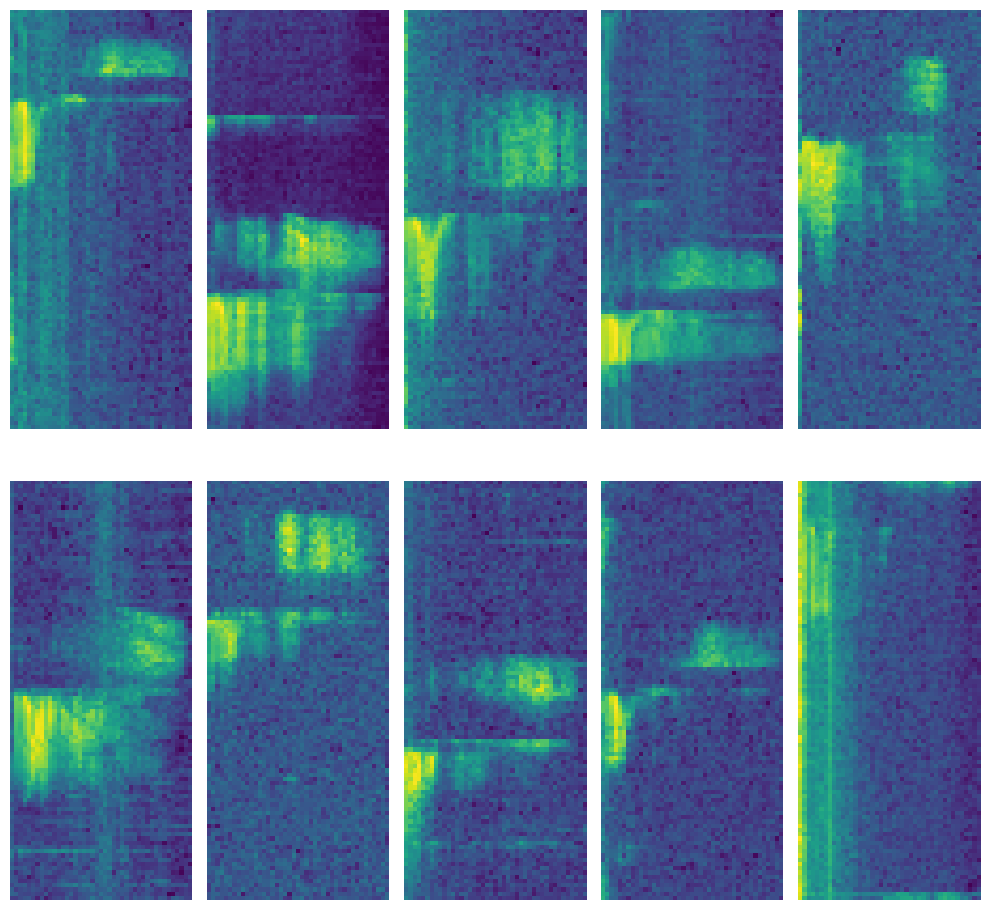

In [ ]:
word_index = command_words.index("stop")

X_stop = np.array(X_train)[np.array(Y_train) == word_index]
plot_images2(X_stop[:10], IMG_WIDTH, IMG_HEIGHT)

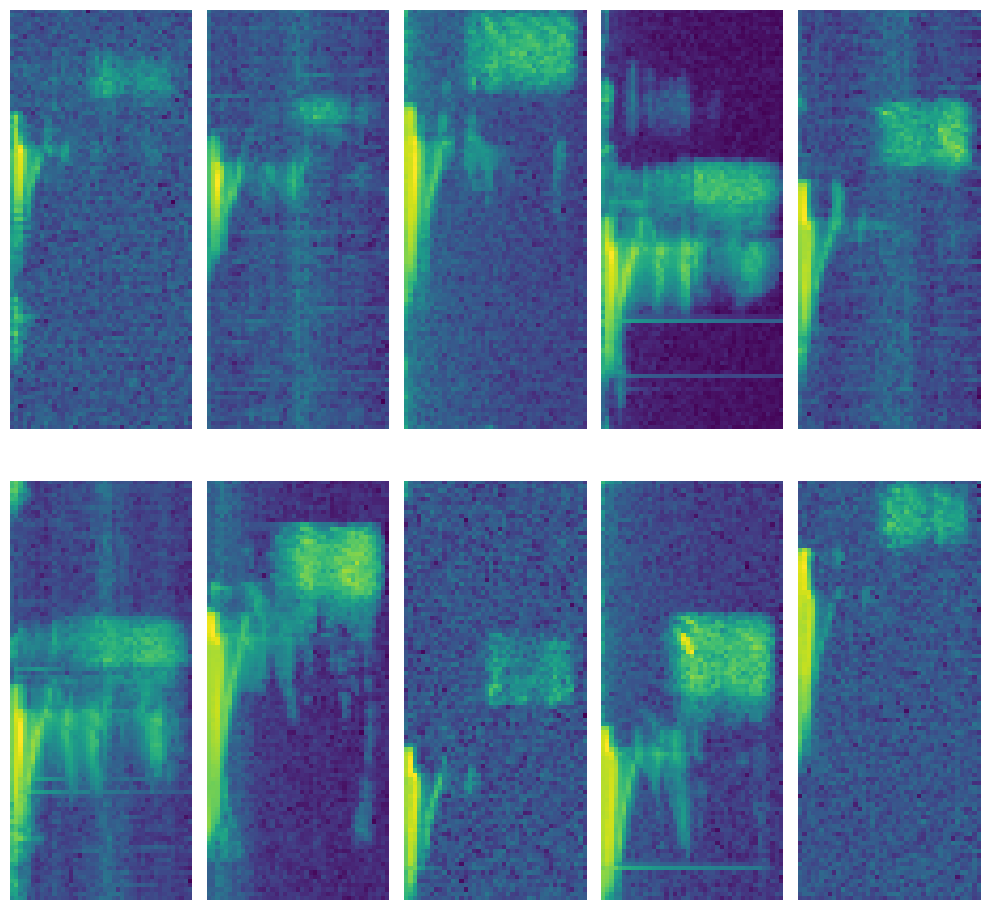

In [ ]:
word_index = command_words.index("slow")

X_right = np.array(X_train)[np.array(Y_train) == word_index]
plot_images2(X_right[:10], IMG_WIDTH, IMG_HEIGHT)